Code to generate and analyze the Liouville spectrum of the 3 level atom case

In [2]:
import qutip as qt
import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
plt.rcParams.update({
    # LaTeX rendering and font configuration
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],  # mathpazo corresponds to Palatino font
    "font.size": 18,  # Base font size
    
    # Font sizes for specific elements
    "axes.titlesize": 22,        # Axis title
    "axes.labelsize": 20,         # Axis labels
    "xtick.labelsize": 18,        # X-ticks
    "ytick.labelsize": 18,        # Y-ticks
    "legend.fontsize": 18,        # Legend
    "figure.titlesize": 24,       # Figure title
    
    # LaTeX preamble packages
    "text.latex.preamble": r"""
        \usepackage{amsmath}
        \usepackage{amsfonts}
        \usepackage{amssymb}
        \usepackage{lmodern}
        \usepackage{mathpazo}
    """
})

In [54]:
# Parameters
g, κ = 0.1, 1.0
Δ1, Δ2 = 2*np.pi * 1.0*g ,-2*np.pi *1.0*g
ϕ = 0
η = 0.5*g 

N = 4  # Number of atoms (adjust as needed)


Omega = 2*η*g/κ    # Rabi drive strength
varphi = np.pi/2   # Phase 
gamma = 4*g*g/(N*κ)     # Dissipation rate
Delta_1 = Δ1    # Detuning of state 1 from 0
Delta_2 = Δ2   # Detuning of state 2 from 0



# Single-atom operators
sigma_01 = qt.projection(3, 0, 1)  # |0⟩⟨1|
sigma_02 = qt.projection(3, 0, 2)  # |0⟩⟨2|
sigma_10 = sigma_01.dag()
sigma_20 = sigma_02.dag()
proj_1 = qt.projection(3, 1, 1)    # |1⟩⟨1|
proj_2 = qt.projection(3, 2, 2)    # |2⟩⟨2|
id3 = qt.qeye(3)                   # Identity for a single atom

# Initialize composite operators for N atoms
H_detuning = 0
H_drive = 0
c_ops = []

for i in range(N):
    # Detuning terms for atom i
    H_detuning_i = (
        Delta_1 * qt.tensor([id3]*i + [proj_1] + [id3]*(N-i-1)) +
        Delta_2 * qt.tensor([id3]*i + [proj_2] + [id3]*(N-i-1)))
    H_detuning += H_detuning_i

    # Drive terms for atom i
    drive_i = Omega * (
        qt.tensor([id3]*i + [sigma_01] + [id3]*(N-i-1)) +
        qt.tensor([id3]*i + [sigma_10] + [id3]*(N-i-1)) +
        np.exp(-1j * varphi) * qt.tensor([id3]*i + [sigma_02] + [id3]*(N-i-1)) +
        np.exp(-1j * varphi) * qt.tensor([id3]*i + [sigma_20] + [id3]*(N-i-1)))
    H_drive += drive_i

    # Dissipator for atom i
    L_i = np.sqrt(gamma) * (
        qt.tensor([id3]*i + [sigma_01] + [id3]*(N-i-1)) +
        np.exp(-1j * varphi) * qt.tensor([id3]*i + [sigma_02] + [id3]*(N-i-1)))
    c_ops.append(L_i)

# Full Hamiltonian and Liouvillian
H = H_detuning + H_drive
liouv = qt.liouvillian(H, c_ops)

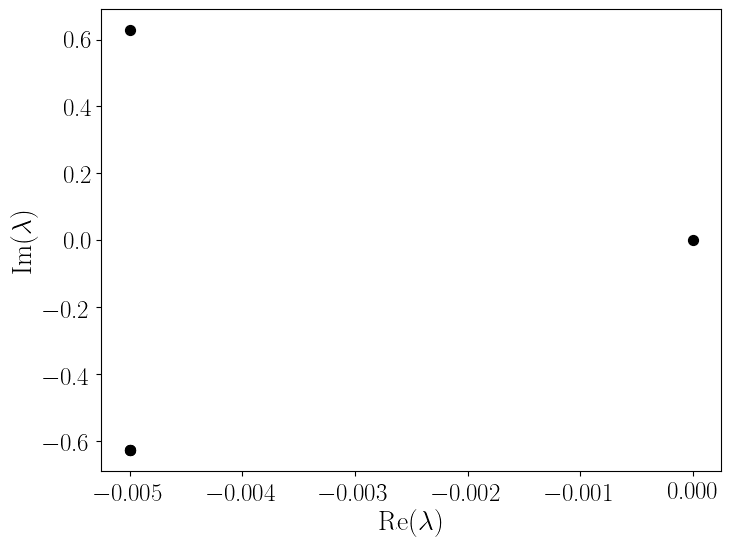

In [55]:
eigenvalues = liouv.eigenenergies(sparse=True, sort='high',eigvals=N+1)
sorted_indices = np.argsort(-np.real(eigenvalues))
eigenvalues = eigenvalues[sorted_indices]

# Plot eigenvalues
real_parts = np.real(eigenvalues)
imag_parts = np.imag(eigenvalues)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(real_parts, imag_parts, color='black', label='Eigenvalues', s=50)

# Highlight the steady state (eigenvalue closest to zero)
# steady_state_idx = np.argmin(np.abs(real_parts))
# plt.scatter(real_parts[steady_state_idx], imag_parts[steady_state_idx], 
#             color='red', s=100, label='Steady State', marker='*')

plt.xlabel(r'Re($\lambda$)')
plt.ylabel(r'Im($\lambda$)')
# plt.xlim(-1e-4,0)


plt.show()

In [57]:
np.real(eigenvalues[1])

np.float64(-0.004996196481075942)

Scaling of Liouvillian gap

In [ ]:
def dominant_gap_real(N):
    """
    Build the N-atom Liouvillian, compute its low-lying spectrum,
    and return the real part of the first nonzero eigenvalue (the gap).
    """
    gamma = 4*g*g/(N*κ)     # Dissipation rate

    # Single-atom operators
    id3     = qt.qeye(3)
    s01, s02 = qt.projection(3,0,1), qt.projection(3,0,2)
    s10, s20 = s01.dag(), s02.dag()
    p1, p2   = qt.projection(3,1,1), qt.projection(3,2,2)

    H_det = 0
    H_drv = 0
    c_ops = []

    for i in range(N):
        # Detuning
        H_det += (Δ1 * qt.tensor([id3]*i + [p1]   + [id3]*(N-i-1))
                + Δ2 * qt.tensor([id3]*i + [p2]   + [id3]*(N-i-1)))
        # Coherent drive
        H_drv += Omega * (
            qt.tensor([id3]*i + [s01] + [id3]*(N-i-1))
          + qt.tensor([id3]*i + [s10] + [id3]*(N-i-1))
          + np.exp(-1j*varphi)*qt.tensor([id3]*i + [s02] + [id3]*(N-i-1))
          + np.exp(-1j*varphi)*qt.tensor([id3]*i + [s20] + [id3]*(N-i-1))
        )
        # Collective jump
        L = np.sqrt(gamma) * (
            qt.tensor([id3]*i + [s01] + [id3]*(N-i-1))
          + np.exp(-1j*varphi)*qt.tensor([id3]*i + [s02] + [id3]*(N-i-1))
        )
        c_ops.append(L)

    L = qt.liouvillian(H_det + H_drv, c_ops)
    # ask for a few smallest-in-magnitude eigenvalues
    eigs = L.eigenenergies(sparse=True, sort='high',eigvals=N+1)
    # sort by descending real part: zero mode first
    idx  = np.argsort(-np.real(eigs))
    eigs = eigs[idx]
    # return the gap (second entry)
    return -1*np.real(eigs[1])

# Sweep N = 1…N
Ns   = np.arange(1,6)
gaps = np.array([dominant_gap_real(N) for N in Ns])

In [ ]:
# Fit gap = a (1/N) + b
x      = 1/Ns
a, b   = np.polyfit(x, gaps, 1)
fit    = a*x + b

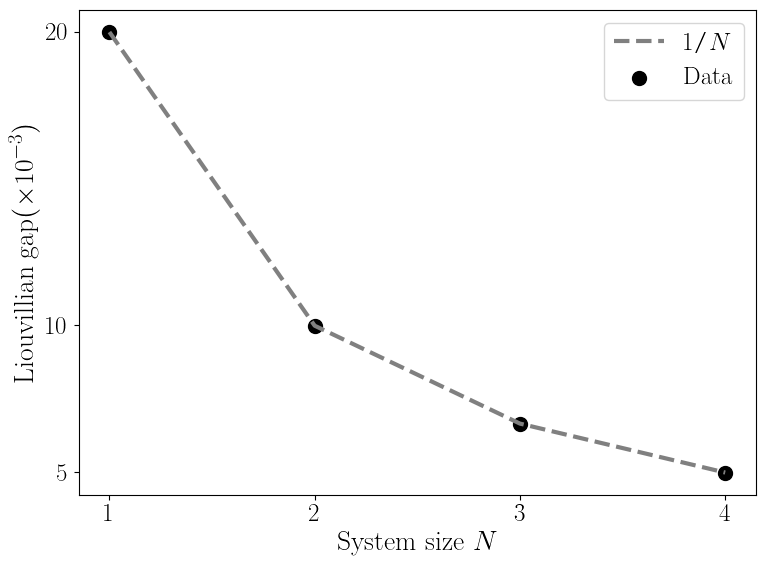

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(Ns, fit, linestyle='--', color='grey',label=r'$1/N$', lw=3)
plt.scatter(Ns, gaps, color='black', s=100, label='Data')
plt.xlabel('System size $N$')
plt.ylabel(r'$\mathrm{Liouvillian\; gap } (\times10^{-3})$')
plt.legend()
plt.yticks([0.02, 0.01, 0.005],[20,10,5])
plt.xticks([1,2,3,4])
plt.tight_layout()
plt.show()

In [221]:
# print(np.real(eigenvalues))
# print(np.imag(eigenvalues))

print(eigenvalues)

[ 6.65755884e-17+4.74443016e-17j -9.99746183e-03+5.12319451e-11j
 -9.99746183e-03+5.12318645e-11j -1.48145950e-02+6.19179375e-01j
 -1.48145950e-02+6.19179375e-01j -1.48148361e-02-6.36508017e-01j
 -1.48148361e-02-6.36508017e-01j -1.48354173e-02+1.93727165e-02j
 -1.48354173e-02+1.93727165e-02j -1.51645848e-02-1.93729192e-02j
 -1.51645848e-02-1.93729192e-02j -1.51826244e-02-6.19173347e-01j
 -1.51826244e-02-6.19173347e-01j -1.51828656e-02+6.36502314e-01j
 -1.51828656e-02+6.36502314e-01j -1.99949237e-02+1.02464019e-10j
 -2.00076150e-02-1.21458044e-07j -2.00076150e-02-1.21458044e-07j
 -2.48120568e-02+6.19179375e-01j -2.48120568e-02+6.19179375e-01j
 -2.48122980e-02-6.36508017e-01j -2.48122980e-02-6.36508017e-01j
 -2.48328791e-02+1.93727165e-02j -2.48328791e-02+1.93727165e-02j
 -2.51620466e-02-1.93729192e-02j -2.51620466e-02-1.93729192e-02j
 -2.51800862e-02-6.19173347e-01j -2.51800862e-02-6.19173347e-01j
 -2.51803274e-02+6.36502314e-01j -2.51803274e-02+6.36502314e-01j
 -2.96291899e-02+1.238358

In [181]:
eigs, eigenvectors = liouv.eigenstates()
# sorted_indices = np.argsort(-np.real(eigenvectors))
# eigenvectors = eigenvectors[sorted_indices]

In [194]:
eigs[-4]

np.complex128(-2.2724877535296173e-16+0.628318530717958j)

In [172]:
sorted_indices = np.argsort(-np.real(eigs))
eigssort = eigs[sorted_indices]

In [ ]:
Qobj(np.reshape(np.array(eigenvectors[-3].full()), (3,3)))

Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 4.35381633e-16-8.17158535e-16j  7.06928459e-01+0.00000000e+00j
  -4.96043474e-16-7.06928459e-01j]
 [ 2.73991633e-16-4.43371465e-17j -1.12057009e-02+7.13377074e-04j
   7.13377074e-04+1.12057009e-02j]
 [-5.32045758e-17-3.28789960e-16j  7.13377074e-04+1.12057009e-02j
   1.12057009e-02-7.13377074e-04j]]

In [190]:
Qobj(np.reshape(np.array(eigenvectors[-4].full()), (3,3)))

Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 2.24950869e-02-1.79010214e-04j -3.58020427e-04+2.84903604e-06j
   2.84903604e-06+3.58020427e-04j]
 [ 7.06748749e-01+0.00000000e+00j -1.12482557e-02-3.38425171e-17j
  -1.35388162e-16+1.12482557e-02j]
 [ 1.12475434e-02+7.06659244e-01j -1.79010214e-04-1.12468312e-02j
  -1.12468312e-02+1.79010214e-04j]]

In [197]:
eigsL, eigvecsL = liouv.dag().eigenstates()

In [205]:
(Qobj(np.reshape(np.array(eigvecsL[-3].full()), (3,3))) * proj_1).tr()

(0.08314612461701186+0.467891472630691j)